# Weather Image Classification with PyTorch

This project builds and compares three neural network models for classifying weather images into four categories: **Cloudy**, **Rain**, **Shine**, and **Sunrise**.

The models implemented are:
1.  A simple **Fully-Connected Network (FCN)**
2.  A custom **Convolutional Neural Network (CNN)**
3.  A **Transfer Learning** model using a pre-trained **ResNet-18**

## 1. Setup and Imports

First, we import the necessary libraries and set up the device (GPU if available) and random seeds for reproducibility.

In [1]:
import os
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cpu


In [3]:
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## 2. Data Loading & Preprocessing

We define a custom `Dataset` class to load, resize, and transform our images. The dataset is expected to be in the `./data/Multi-class Weather Dataset/` directory.


In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, **kwargs):
        self.data = data
        self.labels = labels
        self.label_map = {'Cloudy': 0, 'Rain' : 1, 'Shine': 2, 'Sunrise':3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        image = Image.open(self.data[i]).convert("RGB").resize((224, 224))

        image_tensor = ToTensor()(image)

        label_name = self.labels[i]
        label_index = self.label_map[label_name]
        label_tensor = torch.tensor(label_index, dtype=torch.long)

        return image_tensor, label_tensor

def get_data_and_labels(data_dir):
    """Reads the data directory and returns a list of file paths and labels."""
    files = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for f in os.listdir(class_dir):
            file_path = os.path.join(class_dir, f)
            files.append(file_path)
            labels.append(class_name)

    return np.array(files), np.array(labels)


### Train-Validation-Test Split

We split the data into 70% training, 10% validation, and 20% test sets.

In [ ]:
DATA_DIR = "./data/Multi-class Weather Dataset/"
data, labels = get_data_and_labels(DATA_DIR)

x_train_val, x_test, y_train_val, y_test = train_test_split(
    data, labels, test_size=0.20, shuffle=True, random_state=42, stratify=labels
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.125, shuffle=True, random_state=42, stratify=y_train_val
)

train_dataset = CustomDataset(x_train, y_train)
validation_dataset = CustomDataset(x_val, y_val)
test_dataset =  CustomDataset(x_test, y_test)

print(f"Training set length:   {len(train_dataset)}")
print(f"Validation set length: {len(validation_dataset)}")
print(f"Testing set length:    {len(test_dataset)}")
print(f"Total length:        {len(train_dataset) + len(validation_dataset) + len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training set length:   787
Validation set length: 113
Testing set length:    225
Total length:        1125


## 3. Model Definitions

We define two custom models from scratch: a Fully-Connected Network (FCN) and a Convolutional Neural Network (CNN).

### Convolutional Neural Network (CNN) Model

This model includes 3 CONV + POOL blocks. The channel sizes are [16, 32, 64].

In [10]:
class ConvNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # Input shape: (B, 3, 224, 224)
        self.layer1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # (B, 16, 224, 224)
        self.p1 = nn.MaxPool2d(kernel_size=2, stride=2) # (B, 16, 112, 112)

        self.layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # (B, 32, 112, 112)
        self.p2 = nn.MaxPool2d(kernel_size=2, stride=2) # (B, 32, 56, 56)

        self.layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # (B, 64, 56, 56)
        self.p3 = nn.MaxPool2d(kernel_size=2, stride=2) # (B, 64, 28, 28)

        self.fc = nn.Linear(28*28*64, 4)


    def forward(self, var):
        var = F.relu(self.layer1(var))
        var = self.p1(var)
        var = F.relu(self.layer2(var))
        var = self.p2(var)
        var = F.relu(self.layer3(var))
        var = self.p3(var)
        var = var.reshape(var.shape[0], -1)
        var = self.fc(var)
        return var

### Fully Connected Network (FCN) Model

This model flattens the input image and passes it through three Linear layers with feature sizes [1024, 512, 256].

In [11]:
class FCNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.l1 = nn.Linear(224*224*3, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 256)
        self.fc = nn.Linear(256, 4)

    def forward(self, var):
        var = F.relu(self.l1(var))
        var = F.relu(self.l2(var))
        var = F.relu(self.l3(var))
        var = self.fc(var)
        return var

## 4. Model 1: FCN Training & Evaluation

### FCN Training


In [12]:
max_epoch = 20
learning_rate = 4e-3
momentum = 0.8
weight_decay = 1e-04
model_FCN = FCNet().to(device)

loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_FCN.parameters(), learning_rate, momentum, weight_decay)

train_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []

for epoch in range(max_epoch):
    model_FCN.train()
    train_true = 0
    current_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        x_batch = x_batch.view((x_batch.shape[0], -1))

        outputs = model_FCN(x_batch)
        loss = loss_f(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        train_true += (outputs.argmax(dim=1) == y_batch).type(torch.float).sum().item()

    val_true = 0
    val_current_loss = 0.0
    model_FCN.eval()
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            x_batch = x_batch.view((x_batch.shape[0], -1))

            outputs = model_FCN(x_batch)
            loss = loss_f(outputs, y_batch)

            val_current_loss += loss.item()
            val_true += (outputs.argmax(dim=1) == y_batch).type(torch.float).sum().item()

    train_losses.append(current_loss / len(train_loader))
    training_accuracy.append(100 * train_true / len(train_dataset))
    validation_losses.append(val_current_loss / len(val_loader))
    validation_accuracy.append(100. * val_true / len(validation_dataset))

    print(f"Epoch: {epoch}")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Acc: {training_accuracy[-1]:.2f}%")
    print(f"  Val Loss:   {validation_losses[-1]:.4f}, Val Acc:   {validation_accuracy[-1]:.2f}%")

Epoch: 0
  Train Loss: 1.2714, Train Acc: 46.89%
  Val Loss:   1.0610, Val Acc:   53.98%
Epoch: 1
  Train Loss: 0.9261, Train Acc: 60.48%
  Val Loss:   0.7711, Val Acc:   71.68%
Epoch: 2
  Train Loss: 0.7221, Train Acc: 73.70%
  Val Loss:   0.6375, Val Acc:   74.34%
Epoch: 3
  Train Loss: 0.6133, Train Acc: 79.16%
  Val Loss:   0.6224, Val Acc:   75.22%
Epoch: 4
  Train Loss: 0.5964, Train Acc: 78.65%
  Val Loss:   0.6403, Val Acc:   76.11%
Epoch: 5
  Train Loss: 0.5252, Train Acc: 81.70%
  Val Loss:   0.5886, Val Acc:   76.99%
Epoch: 6
  Train Loss: 0.5222, Train Acc: 81.19%
  Val Loss:   0.5822, Val Acc:   76.11%
Epoch: 7
  Train Loss: 0.4767, Train Acc: 82.08%
  Val Loss:   0.6453, Val Acc:   73.45%
Epoch: 8
  Train Loss: 0.5608, Train Acc: 78.27%
  Val Loss:   0.7417, Val Acc:   67.26%
Epoch: 9
  Train Loss: 0.4850, Train Acc: 81.70%
  Val Loss:   0.5538, Val Acc:   77.88%
Epoch: 10
  Train Loss: 0.4359, Train Acc: 85.01%
  Val Loss:   0.6012, Val Acc:   73.45%
Epoch: 11
  Train Lo

### FCN Learning Curves

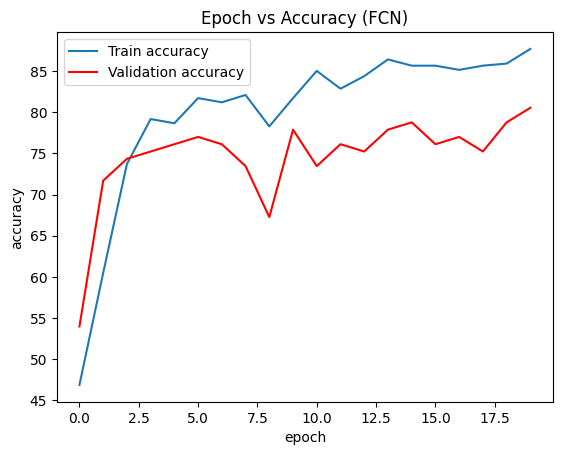

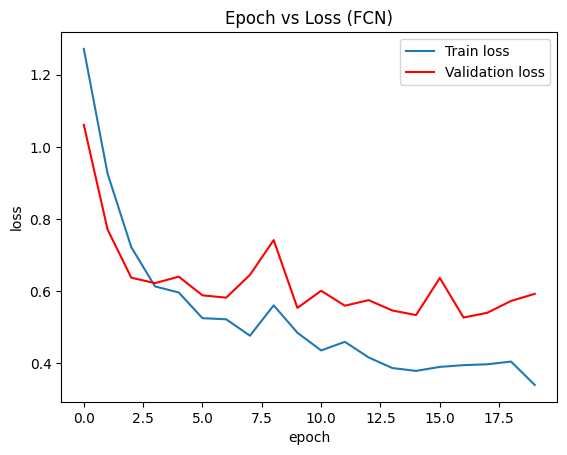

In [13]:
plt.plot(training_accuracy, label = "Train accuracy")
plt.plot(validation_accuracy, "r", label = "Validation accuracy")
plt.legend()
plt.title('Epoch vs Accuracy (FCN)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(train_losses, label = "Train loss")
plt.plot(validation_losses, "r", label = "Validation loss")
plt.legend()
plt.title('Epoch vs Loss (FCN)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### FCN Test & Evaluation

We evaluate the trained FCN on the test set.


Accuracy:  0.7866666666666666
Precision:  0.78834534987704
Recall:  0.7696691778578447
F1 Score:  0.775645973261515


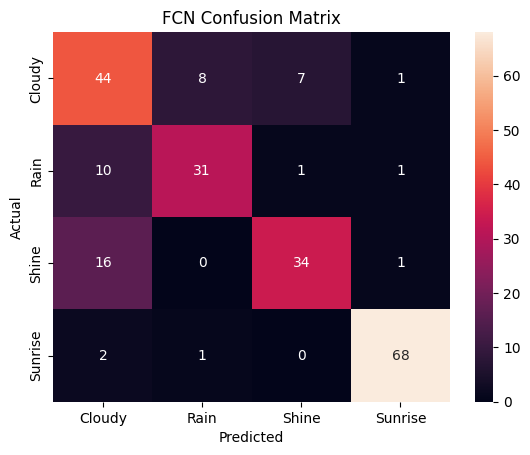

In [14]:
y_prediction = np.array([])
y_real = np.array([])
model_FCN.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        x_batch = x_batch.view((x_batch.shape[0], -1))

        outputs = model_FCN(x_batch).cpu()
        y_prediction = np.append(y_prediction, outputs.argmax(dim = 1).numpy())

        y_real = np.append(y_real, y_batch.numpy())

print("Accuracy: ", accuracy_score(y_real, y_prediction))
print("Precision: ", precision_score(y_real, y_prediction, average='macro'))
print("Recall: ", recall_score(y_real, y_prediction, average='macro'))
print("F1 Score: " , f1_score(y_real, y_prediction, average='macro'))

matrix = confusion_matrix(y_real, y_prediction)
class_names = list(train_dataset.label_map.keys())
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('FCN Confusion Matrix')
plt.show()

## 5. Model 2: CNN Training & Evaluation

### CNN Training


In [15]:
max_epoch = 20
learning_rate = 4e-3
momentum = 0.8
weight_decay = 1e-04
model_CNN = ConvNet().to(device)

loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_CNN.parameters(), learning_rate, momentum, weight_decay)

train_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []

for epoch in range(max_epoch):
    model_CNN.train()
    train_true = 0
    current_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        outputs = model_CNN(x_batch)
        loss = loss_f(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        train_true += (outputs.argmax(dim=1) == y_batch).type(torch.float).sum().item()

    val_true = 0
    val_current_loss = 0.0
    model_CNN.eval()
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outputs = model_CNN(x_batch)
            loss = loss_f(outputs, y_batch)

            val_current_loss += loss.item()
            val_true += (outputs.argmax(dim=1) == y_batch).type(torch.float).sum().item()

    train_losses.append(current_loss / len(train_loader))
    training_accuracy.append(100 * train_true / len(train_dataset))
    validation_losses.append(val_current_loss / len(val_loader))
    validation_accuracy.append(100. * val_true / len(validation_dataset))

    print(f"Epoch: {epoch}")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Acc: {training_accuracy[-1]:.2f}%")
    print(f"  Val Loss:   {validation_losses[-1]:.4f}, Val Acc:   {validation_accuracy[-1]:.2f}%")

Epoch: 0
  Train Loss: 1.3662, Train Acc: 30.88%
  Val Loss:   1.3123, Val Acc:   31.86%
Epoch: 1
  Train Loss: 1.2256, Train Acc: 46.51%
  Val Loss:   1.0469, Val Acc:   65.49%
Epoch: 2
  Train Loss: 0.8631, Train Acc: 65.95%
  Val Loss:   0.7000, Val Acc:   78.76%
Epoch: 3
  Train Loss: 0.6394, Train Acc: 79.67%
  Val Loss:   0.8607, Val Acc:   58.41%
Epoch: 4
  Train Loss: 0.7521, Train Acc: 67.98%
  Val Loss:   0.6011, Val Acc:   79.65%
Epoch: 5
  Train Loss: 0.5606, Train Acc: 78.27%
  Val Loss:   0.5552, Val Acc:   76.11%
Epoch: 6
  Train Loss: 0.4836, Train Acc: 82.97%
  Val Loss:   0.5517, Val Acc:   74.34%
Epoch: 7
  Train Loss: 0.4702, Train Acc: 83.10%
  Val Loss:   0.5353, Val Acc:   77.88%
Epoch: 8
  Train Loss: 0.5380, Train Acc: 80.05%
  Val Loss:   0.5270, Val Acc:   76.11%
Epoch: 9
  Train Loss: 0.4933, Train Acc: 84.12%
  Val Loss:   0.5391, Val Acc:   76.11%
Epoch: 10
  Train Loss: 0.4767, Train Acc: 83.61%
  Val Loss:   0.4964, Val Acc:   82.30%
Epoch: 11
  Train Lo

### CNN Learning Curves

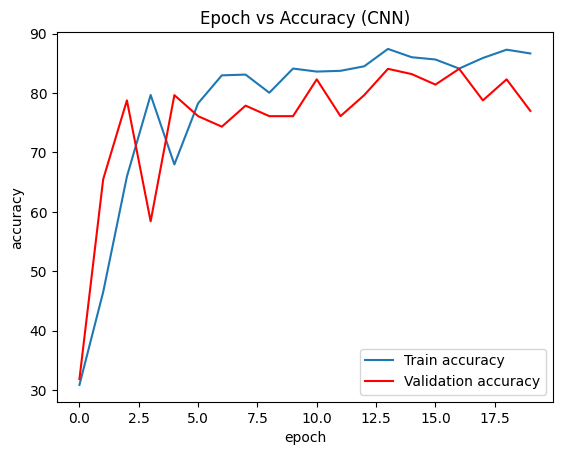

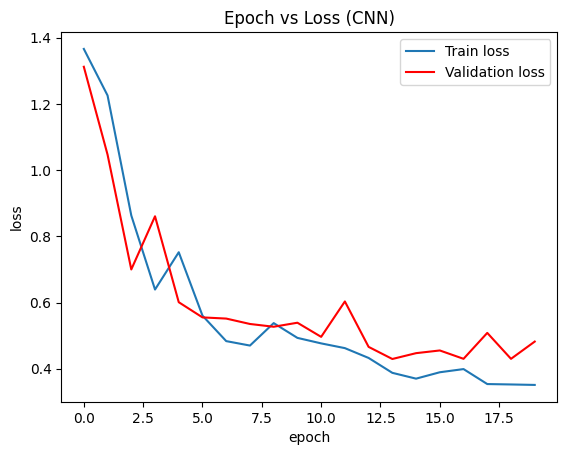

In [16]:
plt.plot(training_accuracy, label = "Train accuracy")
plt.plot(validation_accuracy, "r", label = "Validation accuracy")
plt.legend()
plt.title('Epoch vs Accuracy (CNN)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(train_losses, label = "Train loss")
plt.plot(validation_losses, "r", label = "Validation loss")
plt.legend()
plt.title('Epoch vs Loss (CNN)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### CNN Test & Evaluation

Accuracy:  0.7911111111111111
Precision:  0.820743479061353
Recall:  0.8003363775906694
F1 Score:  0.7638881919195144


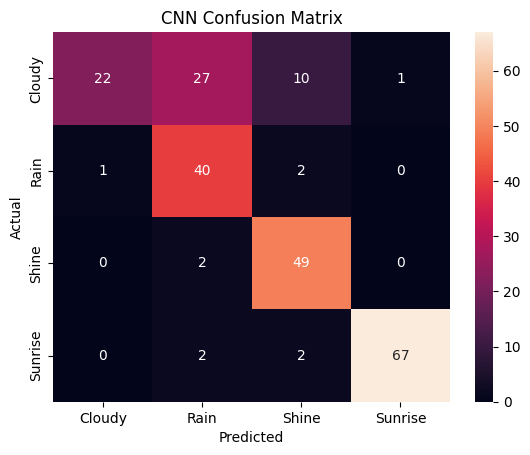

In [17]:
y_prediction = np.array([])
y_real = np.array([])
model_CNN.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)

        outputs = model_CNN(x_batch).cpu()
        y_prediction = np.append(y_prediction, outputs.argmax(dim = 1).numpy())

        y_real = np.append(y_real, y_batch.numpy())

print("Accuracy: ", accuracy_score(y_real, y_prediction))
print("Precision: ", precision_score(y_real, y_prediction, average='macro'))
print("Recall: ", recall_score(y_real, y_prediction, average='macro'))
print("F1 Score: " , f1_score(y_real, y_prediction, average='macro'))

matrix = confusion_matrix(y_real, y_prediction)
class_names = list(train_dataset.label_map.keys())
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('CNN Confusion Matrix')
plt.show()

## 6. Model 3: Transfer Learning (ResNet-18)

Finally, we use a pre-trained ResNet-18 model from `torchvision`. We freeze all layers except for the final fully-connected (fc) layer, which we replace with a new `nn.Linear` layer matching our 4 output classes. This is a common *feature extraction* approach in transfer learning.

### ResNet-18 Training

In [18]:
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion, device):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

max_epoch = 10
learning_rate = 4e-3
momentum = 0.8
weight_decay = 1e-04
model_TL = models.resnet18(pretrained=True)

# Freeze all parameters
for params in model_TL.parameters():
    params.requires_grad = False

# Replace the final layer
model_TL.fc = nn.Linear(model_TL.fc.in_features, 4)

model_TL.to(device)

# Only the new fc layer has requires_grad=True, so only it will be updated.
optimizer = torch.optim.SGD(model_TL.parameters(), learning_rate, momentum, weight_decay)
loss_f = nn.CrossEntropyLoss()

training_accuracy = []
train_losses = []
validation_accuracy = []
validation_losses = []

for epoch in range(max_epoch):
        train_epoch_loss, train_epoch_acc = train(
            model_TL,
            train_loader,
            optimizer,
            loss_f,
            device
        )
        valid_epoch_loss, valid_epoch_acc = validate(
            model_TL,
            val_loader,
            loss_f,
            device
        )
        train_losses.append(train_epoch_loss)
        validation_losses.append(valid_epoch_loss)
        training_accuracy.append(train_epoch_acc)
        validation_accuracy.append(valid_epoch_acc)
        print(f"Epoch: {epoch}")
        print(f"  Training Loss: {train_epoch_loss:.3f}, Training Accuracy: {train_epoch_acc:.3f}%")
        print(f"  Validation Loss: {valid_epoch_loss:.3f}, validation Accuracy: {valid_epoch_acc:.3f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]
100%|██████████| 2/2 [00:12<00:00,  6.36s/it]


Epoch: 0
  Training Loss: 1.156, Training Accuracy: 51.588%
  Validation Loss: 0.822, validation Accuracy: 81.416%


100%|██████████| 2/2 [00:12<00:00,  6.36s/it]


Epoch: 1
  Training Loss: 0.567, Training Accuracy: 87.421%
  Validation Loss: 0.458, validation Accuracy: 91.150%


100%|██████████| 2/2 [00:12<00:00,  6.30s/it]


Epoch: 2
  Training Loss: 0.402, Training Accuracy: 91.741%
  Validation Loss: 0.304, validation Accuracy: 95.575%


100%|██████████| 2/2 [00:12<00:00,  6.34s/it]


Epoch: 3
  Training Loss: 0.337, Training Accuracy: 91.614%
  Validation Loss: 0.262, validation Accuracy: 95.575%


100%|██████████| 2/2 [00:12<00:00,  6.39s/it]


Epoch: 4
  Training Loss: 0.266, Training Accuracy: 94.663%
  Validation Loss: 0.238, validation Accuracy: 95.575%


100%|██████████| 2/2 [00:12<00:00,  6.41s/it]


Epoch: 5
  Training Loss: 0.226, Training Accuracy: 94.917%
  Validation Loss: 0.217, validation Accuracy: 95.575%


100%|██████████| 2/2 [00:12<00:00,  6.19s/it]


Epoch: 6
  Training Loss: 0.217, Training Accuracy: 95.172%
  Validation Loss: 0.201, validation Accuracy: 94.690%


100%|██████████| 2/2 [00:12<00:00,  6.47s/it]


Epoch: 7
  Training Loss: 0.205, Training Accuracy: 95.553%
  Validation Loss: 0.193, validation Accuracy: 94.690%


100%|██████████| 2/2 [00:13<00:00,  6.60s/it]


Epoch: 8
  Training Loss: 0.182, Training Accuracy: 96.061%
  Validation Loss: 0.180, validation Accuracy: 93.805%


100%|██████████| 2/2 [00:12<00:00,  6.31s/it]

Epoch: 9
  Training Loss: 0.178, Training Accuracy: 95.807%
  Validation Loss: 0.178, validation Accuracy: 94.690%


### ResNet-18 Learning Curves

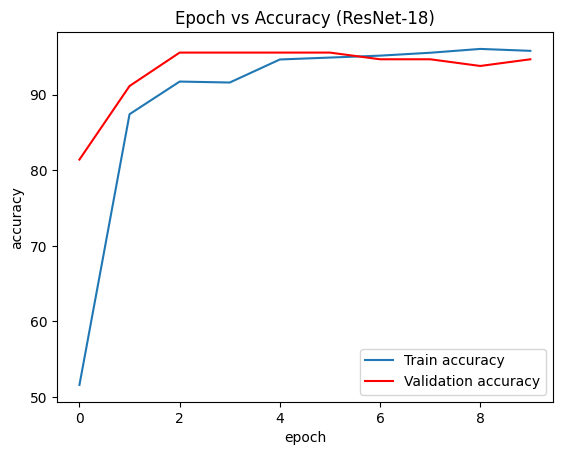

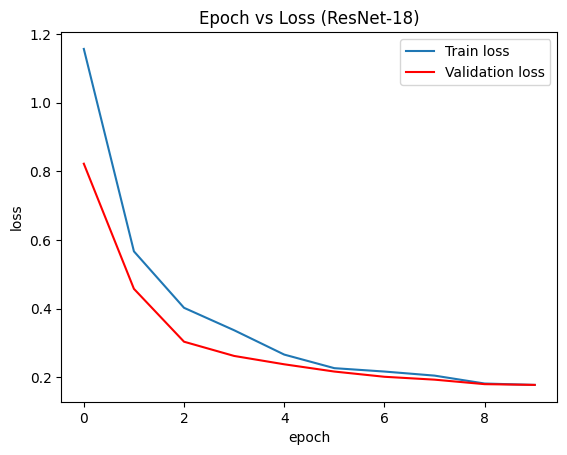

In [19]:
plt.plot(training_accuracy, label = "Train accuracy")
plt.plot(validation_accuracy, "r", label = "Validation accuracy")
plt.legend()
plt.title('Epoch vs Accuracy (ResNet-18)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(train_losses, label = "Train loss")
plt.plot(validation_losses, "r", label = "Validation loss")
plt.legend()
plt.title('Epoch vs Loss (ResNet-18)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### ResNet-18 Test & Evaluation


Accuracy:  0.9688888888888889
Precision:  0.969954648526077
Recall:  0.9662448700410396
F1 Score:  0.967831181252989


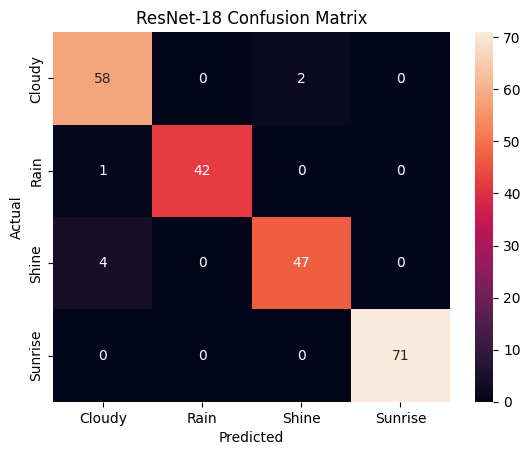

In [20]:
y_prediction = np.array([])
y_real = np.array([])
model_TL.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)

        outputs = model_TL(x_batch).cpu()
        y_prediction = np.append(y_prediction, outputs.argmax(dim = 1).numpy())
        y_real = np.append(y_real, y_batch.numpy())

print("Accuracy: ", accuracy_score(y_real, y_prediction))
print("Precision: ", precision_score(y_real, y_prediction, average='macro'))
print("Recall: ", recall_score(y_real, y_prediction, average='macro'))
print("F1 Score: " , f1_score(y_real, y_prediction, average='macro'))

matrix = confusion_matrix(y_real, y_prediction)
class_names = list(train_dataset.label_map.keys())
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('ResNet-18 Confusion Matrix')
plt.show()